In [1]:
import sympy as sp
from sympy import sin, cos, Matrix, pi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

In [2]:
# Class PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, T):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.T = T
        self.e_km1 = 0
        self.e_km2 = 0
        self.u_km1 = 0

    def compute_control(self, reference, state):
        e_k = reference - state
        
        a0 = self.Kp + self.Kd / self.T
        a1 = self.Ki * self.T - 2 * self.Kd / self.T - self.Kp
        a2 = self.Kd / self.T

        u_k = self.u_km1 + a0 * e_k + a1 * self.e_km1 + a2 * self.e_km2

        self.u_km1 = u_k
        self.e_km2 = self.e_km1
        self.e_km1 = e_k

        return u_k

In [3]:
# Reference trajectory
def reference_trajectory(t):
    return -np.pi / 2 - np.deg2rad(20) * np.cos(t)

# Constants
g = 9.81  # m/s^2
L = 0.4  # m (pendulum length)
m = 16.0  # kg (pendulum mass)
U_M = 16  # V (motor voltage)
R_M = 0.151  # Ohm (resistance)
L_M = 121e-6  # H (inductance)
k_M = 0.03  # Nm/A (torque constant)
i_M = 60  # gear ratio
eta_M = 0.85  # gear efficiency

In [11]:
# Initial values for the simulation
q_0 = reference_trajectory(0)
omega_0 = 0
dt_control = 0.1
dt_sim = 0.01
initial_state = [omega_0, q_0, 1]
t_start = 0
t_end = 10
t_control = np.arange(t_start, t_end, dt_control)

In [12]:
# Pendulum dynamics
def pendulum(t, y, M):
    omega, q = y
    domega = - (g / L) * np.sin(q) + M / (m * L**2)
    dq = omega
    return [domega, dq]

# Drive dynamics
def drive(t, y, u_control, omega):
    M = y
    U = U_M * u_control
    n = i_M * omega * 30 / np.pi  # Convert angular velocity to rpm
    I = M / (eta_M * i_M * k_M)
    dI_dt = (U - R_M * I - n / k_M) / L_M
    dM = eta_M * i_M * k_M * dI_dt
    return [dM]

# Combined system dynamics
def system_equations(t, y, u_control):
    dydt_pendulum = pendulum(t, y[0:2], y[2])
    dydt_drive = drive(t, y[2], u_control, y[0])
    return dydt_pendulum + dydt_drive

In [13]:
# Simulation function with debugging
def simulation(params):
    Kp, Ki, Kd = params
    controller = PIDController(Kp, Ki, Kd, dt_control)
    
    t_total = []
    y_total = []
    u_control_array = []
    ref_array = []

    current_state = initial_state

    for t in t_control:
        ref = reference_trajectory(t)
        measured = current_state[1]
        u_control = controller.compute_control(ref, measured)

        # print(f"t: {t:.2f} Ref: {ref:.2f} measured: {measured:.2f} Control: {u_control:.2f}")

        t_span = [t, min(t + dt_control, t_end)]
        t_eval = np.linspace(t_span[0], t_span[1], int((t_span[1] - t_span[0]) / dt_sim) + 1)

        sol = solve_ivp(system_equations, t_span, current_state, args=(u_control,), t_eval=t_eval, dense_output=True, method='BDF')
        
        current_state = sol.y[:, -1]

        if len(t_total) == 0:
            t_total.extend(sol.t)
            y_total.extend(sol.y.T)
            u_control_array.extend([u_control] * len(sol.t))
            ref_array.extend([ref] * len(sol.t))
        else:
            t_total.extend(sol.t[1:])
            y_total.extend(sol.y[:, 1:].T)
            u_control_array.extend([u_control] * (len(sol.t) - 1))
            ref_array.extend([ref] * (len(sol.t) - 1))

    return t_total, y_total, ref_array, u_control_array


In [14]:
# Objective function for optimization
def cost_function(params):
    t_sol, y_sol, ref_sol, u_control_sol = simulation(params)

    total_error = np.sum(np.abs(np.array(y_sol)[:, 1] - np.array(ref_sol))**2)
    print(f"Kp: {params[0]:.2f} Ki: {params[1]:.2f} Kd: {params[2]:.2f} Error: {total_error:.2f}")

    return total_error

In [15]:
# Initial values for the PID parameters Kp, Ki, Kd
Kp = 6000
Ki = 600
Kd = 1000

initial_params = [Kp, Ki, Kd]

# bounds for the PID parameters
bounds = [(0, 10000), (0, 10000), (0, 10000)]

total_error = 0
total_u_control = 0

# Run the optimization
#result = minimize(cost_function, initial_params, bounds=bounds, method='L-BFGS-B')

# Optimized PID parameters
#Kp, Ki, Kd = result.x
print("Optimized PID parameters: ", Kp, Ki, Kd)

Optimized PID parameters:  6000 600 1000


In [16]:
# Run the simulation with sample PID parameters
t_sol, y_sol, ref_sol, u_control_sol = simulation([Kp, Ki, Kd])

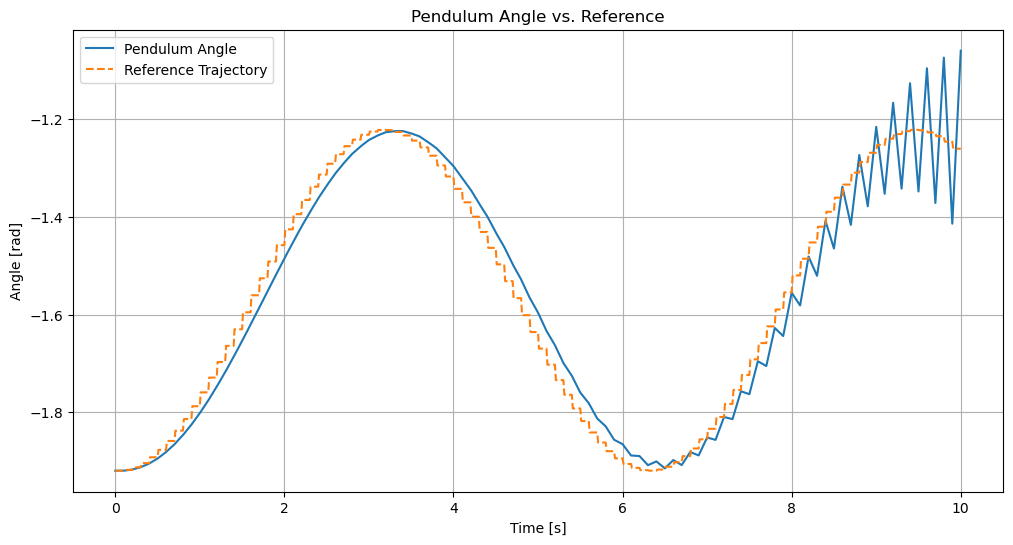

In [17]:
# Extract results
sol_omega = [y[0] for y in y_sol]
sol_q = [y[1] for y in y_sol]
sol_M = [y[2] for y in y_sol]

# Plot pendulum angle and reference angle
plt.figure(figsize=(12, 6))
plt.plot(t_sol, sol_q, label='Pendulum Angle')
plt.plot(t_sol, ref_sol, label='Reference Trajectory', linestyle='--')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Pendulum Angle vs. Reference')
plt.legend()
plt.grid()
plt.show()